In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer # , CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
import pandas as pd
from time import time
import numpy as np
import matplotlib.pyplot as plt 

RAW_DATA_PATH = "processed_data.csv"


classifiers = {
    "SGDClassifier" : SGDClassifier(random_state = 666, class_weight='balanced'),
    #"MultinomialNB" : MultinomialNB(),
    #"svm_cvs" : svm.SVC(C=1, degree=2, gamma='scale', kernel='linear', probability=True, verbose=True),
    #"RandomForestClassifier" : RandomForestClassifier(criterion='entropy', random_state = 666)    
}


df = pd.read_csv(RAW_DATA_PATH)
df.drop(labels=['dnum_p0','dnum_p1'], axis=1, inplace=True, errors='ignore')
df.head()
df.columns

Index(['MachineId', 'MeasurementId', 'p_mean', 'p_median', 'p_std', 'p_var',
       'p_sum', 'p_count', 'PumpFailed', 'SlowStart', 'SlowEnd', 'dnum_p0p',
       'dnum_p1p'],
      dtype='object')

In [34]:
df.dropna(subset=['SlowStart','SlowEnd'], how='any', inplace=True)
for col in df.columns:
    print(col, 'num of nans:', df[col].isna().sum())

MachineId num of nans: 0
MeasurementId num of nans: 0
p_mean num of nans: 0
p_median num of nans: 0
p_std num of nans: 0
p_var num of nans: 0
p_sum num of nans: 0
p_count num of nans: 0
PumpFailed num of nans: 0
SlowStart num of nans: 0
SlowEnd num of nans: 0
dnum_p0p num of nans: 0
dnum_p1p num of nans: 0


In [35]:
feature_cols = ['p_mean', 'p_median', 'p_std', 'p_var', 'p_sum', 'dnum_p0p','dnum_p1p', 'SlowStart', 'SlowEnd']
features = df[feature_cols].copy()
## rescale values
features[feature_cols] = features[feature_cols]  * 100
features['p_sum'] = features['p_sum']  / 100
features

,p_mean,p_median,p_std,p_var,p_sum,dnum_p0p,dnum_p1p,SlowStart,SlowEnd
0,101.490577,108.058252,34.999289,12.249502,138.027184,63.043478,36.956522,0.0,0.0
1,135.482344,146.725318,37.220040,13.853314,260.126100,73.770492,26.229508,0.0,0.0
2,131.953201,145.018797,43.191918,18.655417,294.255639,62.139219,37.860781,0.0,100.0
3,77.956924,77.842566,19.176723,3.677467,167.607386,38.395415,61.604585,0.0,0.0
4,106.442474,114.412417,46.243164,21.384302,182.016630,54.155496,45.844504,0.0,0.0
...,...,...,...,...,...,...,...,...,...
26832,97.959897,95.419847,21.598012,4.664741,208.654580,36.795252,63.204748,0.0,0.0
26833,130.801813,135.832472,28.552271,8.152322,258.987590,58.577406,41.422594,0.0,0.0
26834,83.695446,82.058824,17.856583,3.188576,259.455882,28.899083,71.100917,0.0,0.0
26835,151.759386,154.670330,55.045636,30.300220,291.378022,65.027322,34.972678,0.0,0.0


In [36]:
## we have slighty imbalanced data
X_train, X_test, y_train, y_test = train_test_split(features, df['PumpFailed'], test_size=0.3, random_state=666)
print("train: \n", y_train.value_counts())
print("test: \n", y_test.value_counts())

train: 
 0    11910
1     1555
Name: PumpFailed, dtype: int64
test: 
 0    5167
1     605
Name: PumpFailed, dtype: int64


accuracy: 0.814 
f1 score: 0.434 
[[4287  880]
 [ 193  412]]
confusion matrix:
[[4287  880]
 [ 193  412]]


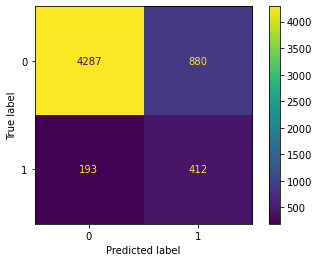

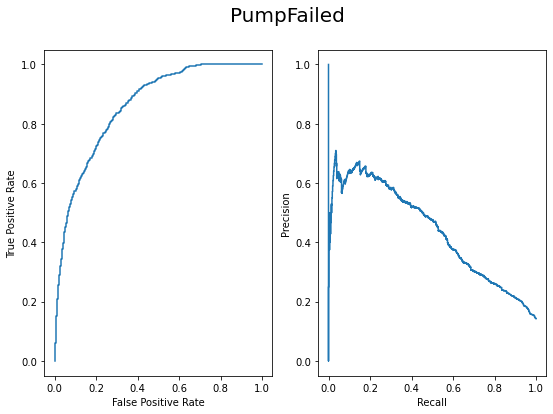

In [39]:
## trying to fit SlowStart / SlowEnd cols
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

#  class_weight='balanced' for imbalanced dist of classes
clf = SGDClassifier(random_state = 666, class_weight='balanced', loss='log')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

#'''
acc_score = metrics.accuracy_score(y_test, y_pred)
#print(type(acc_score))
print('accuracy: {:.3f} '.format( acc_score ))

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score: {:.3f} '.format( f1_score ))

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)#, target_names=['Positive', 'Negative']))
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))
cm_display = ConfusionMatrixDisplay(cm).plot()

y_score = clf.decision_function(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.suptitle("PumpFailed", fontsize=20)
plt.show()
#'''

# poor f1 score, lets try to modify threshold

In [41]:
threshold_list = np.linspace(0.1, 0.95, num=17)
for THRESHOLD in threshold_list:
    print ('\n******** For THRESHOLD = {:.2f} ******'.format(THRESHOLD))

    Y_test_pred = np.where(y_pred_prob[:,1] > THRESHOLD, 1, 0)

    #Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test,Y_test_pred)
    print('accuracy : {}'.format(test_accuracy))
    f1_score = metrics.f1_score(y_test, y_pred)
    print('f1 score: {:.3f} '.format( f1_score ))
    prec = metrics.precision_score(y_test, y_pred)
    print('prec score: {:.3f} '.format( prec ))
    rec = metrics.recall_score(y_test, y_pred)
    print('rec score: {:.3f} '.format( rec ))
    print(metrics.confusion_matrix(y_test, Y_test_pred))


******** For THRESHOLD = 0.10 ******
accuracy : 0.8130630630630631
f1 score: 0.434 
prec score: 0.319 
rec score: 0.681 
[[4279  888]
 [ 191  414]]

******** For THRESHOLD = 0.15 ******
accuracy : 0.8132363132363133
f1 score: 0.434 
prec score: 0.319 
rec score: 0.681 
[[4280  887]
 [ 191  414]]

******** For THRESHOLD = 0.21 ******
accuracy : 0.8135828135828136
f1 score: 0.434 
prec score: 0.319 
rec score: 0.681 
[[4282  885]
 [ 191  414]]

******** For THRESHOLD = 0.26 ******
accuracy : 0.8137560637560638
f1 score: 0.434 
prec score: 0.319 
rec score: 0.681 
[[4283  884]
 [ 191  414]]

******** For THRESHOLD = 0.31 ******
accuracy : 0.8134095634095634
f1 score: 0.434 
prec score: 0.319 
rec score: 0.681 
[[4283  884]
 [ 193  412]]

******** For THRESHOLD = 0.37 ******
accuracy : 0.8135828135828136
f1 score: 0.434 
prec score: 0.319 
rec score: 0.681 
[[4284  883]
 [ 193  412]]

******** For THRESHOLD = 0.42 ******
accuracy : 0.8139293139293139
f1 score: 0.434 
prec score: 0.319 
re

In [44]:
SGDC_GRID = {'fit_intercept': [True, False],
             'early_stopping': [True, False],
             'loss': ['hinge', 'log', 'squared_hinge', 
                      'modified_huber', 'squared_hinge', 'perceptron', 
                      'squared_error', 'huber', 'epsilon_insensitive', 
                      'squared_epsilon_insensitive'],                                       
             'penalty': ['l2', 'l1', 'none']
             }

t = time()
model_sgdc = make_pipeline(
    GridSearchCV(SGDClassifier(random_state=666, class_weight='balanced',max_iter=10000), param_grid=SGDC_GRID, cv=5, refit=True) ### set: refit=True!!!
)
model_sgdc.fit(X_train, y_train)
training_time = time() - t
model_sgdc_y_pred = model_sgdc.predict(X_test)

print(metrics.classification_report(y_test, model_sgdc_y_pred, target_names=['Positive', 'Negative']))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_sgdc[0].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_sgdc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_sgdc_y_pred))
print('#########################------------------------------')

C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\linear_mo

              precision    recall  f1-score   support

    Positive       0.97      0.66      0.79      5167
    Negative       0.23      0.85      0.36       605

    accuracy                           0.68      5772
   macro avg       0.60      0.75      0.57      5772
weighted avg       0.90      0.68      0.74      5772

#########################------------------------------
training time: 552.2 s
------------------------------
model_sgdc.best_params_ {'early_stopping': True, 'fit_intercept': False, 'loss': 'log', 'penalty': 'l2'}
------------------------------
accuracy 0.6798336798336798
------------------------------
confusion matrix:
[[3411 1756]
 [  92  513]]
#########################------------------------------


# summary


******** For THRESHOLD = 0.10 ******
thrsh: 0.10 roc score 1.0

******** For THRESHOLD = 0.15 ******
thrsh: 0.15 roc score 1.0

******** For THRESHOLD = 0.21 ******
thrsh: 0.21 roc score 1.0

******** For THRESHOLD = 0.26 ******
thrsh: 0.26 roc score 1.0

******** For THRESHOLD = 0.31 ******
thrsh: 0.31 roc score 1.0

******** For THRESHOLD = 0.37 ******
thrsh: 0.37 roc score 1.0

******** For THRESHOLD = 0.42 ******
thrsh: 0.42 roc score 1.0

******** For THRESHOLD = 0.47 ******
thrsh: 0.47 roc score 1.0

******** For THRESHOLD = 0.53 ******
thrsh: 0.53 roc score 1.0

******** For THRESHOLD = 0.58 ******
thrsh: 0.58 roc score 1.0

******** For THRESHOLD = 0.63 ******
thrsh: 0.63 roc score 1.0

******** For THRESHOLD = 0.68 ******
thrsh: 0.68 roc score 1.0

******** For THRESHOLD = 0.74 ******
thrsh: 0.74 roc score 1.0

******** For THRESHOLD = 0.79 ******
thrsh: 0.79 roc score 1.0

******** For THRESHOLD = 0.84 ******
thrsh: 0.84 roc score 1.0

******** For THRESHOLD = 0.90 ******
th

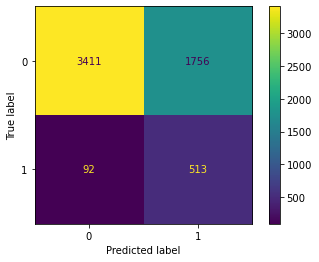

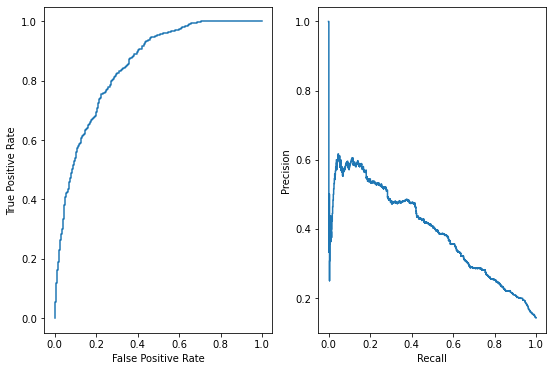

In [54]:
clf = SGDClassifier(random_state=666, class_weight='balanced',max_iter=10000,
                    early_stopping=True, fit_intercept=False, loss='log', penalty='l2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)


threshold_list = np.linspace(0.1, 0.95, num=17)
roc_score = 0
thrsh_score = np.nan
for THRESHOLD in threshold_list:
    print ('\n******** For THRESHOLD = {:.2f} ******'.format(THRESHOLD))

    Y_test_pred = np.where(y_pred_prob[:,1] > THRESHOLD, 1, 0)
    Y_test_pred = (y_pred_prob[:,1] >= THRESHOLD).astype('int')
    
    if roc_score < metrics.roc_auc_score(y_pred, Y_test_pred):
        roc_score = metrics.roc_auc_score(y_pred, Y_test_pred)
        thrsh_score = THRESHOLD
    print('thrsh: {:.2f}'.format(THRESHOLD), 'roc score', metrics.roc_auc_score(y_pred, Y_test_pred))

print('opt thrsh: {:.2f}'.format(THRESHOLD), 'roc score', roc_score)
'''
    #Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test,Y_test_pred)
    print('accuracy : {}'.format(test_accuracy))
    f1_score = metrics.f1_score(y_test, y_pred)
    print('f1 score: {:.3f} '.format( f1_score ))
    prec = metrics.precision_score(y_test, y_pred)
    print('prec score: {:.3f} '.format( prec ))
    rec = metrics.recall_score(y_test, y_pred)
    print('rec score: {:.3f} '.format( rec ))
    ## compute roc_score to find the best threshold
    metrics.roc_auc_score
    
    print(metrics.confusion_matrix(y_test, Y_test_pred))
'''


cm = metrics.confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

y_score = clf.decision_function(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
#plt.suptitle(missing_col, fontsize=20)
plt.show()

### not sure why in the code above, roc measure is mostly = to 1 ?!! 

# lets try to incorporate more information form measurements
e.g. histogram bins

In [61]:
# load raw data again:
DATA_RAW_PATH = "data/data.parquet"
DATA_LABELS_PATH = "data/labels.csv"

data = pd.read_parquet(DATA_RAW_PATH)
labels = pd.read_csv(DATA_LABELS_PATH)

In [68]:
### create bins for min and max values 
_bins = np.linspace(0,7,29)

def get_hist(vals, bins=_bins):
    return np.histogram(vals, bins=bins, density=True)[0]

# group data, get histogram values from Pressure measurements ...
mame_g = data.groupby(['MachineId', 'MeasurementId']).Pressure.apply(list).reset_index(name ='Pressure')
mame_g['hist_vals'] = mame_g.Pressure.apply(get_hist) #.astype(int)
df_mame_g = mame_g.merge(labels, on=['MachineId','MeasurementId'])
df_mame_g.dropna(subset=['PumpFailed'], inplace=True) # , axis=0, how='any'
df_mame_g.head()

,MachineId,MeasurementId,Pressure,hist_vals,PumpFailed,SlowStart,SlowEnd
1,0_0_0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.619565217391304, 0.043478260869565216, 0.07...",False,False,False
2,0_0_0,215,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.989071038251366, 0.02185792349726776, 0.049...",False,False,False
3,0_0_0,237,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.533106960950764, 0.12903225806451613, 0.020...",False,False,True
4,0_0_0,353,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6045845272206303, 0.045845272206303724, 0.8...",False,False,False
5,0_0_0,411,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.3270777479892764, 0.17158176943699732, 0.10...",True,False,False


### its not optimal, so lets try to improve features that are used in the model
#### histograms
##### I got stuck with this step for apporx 2h : convert values in a list in a pd column into vector/matrix that could be used  to train the model.
##### atm 'easy' workaround to create a new col for each value; this solution is not optimal, as it would not be much efficient for larger datasets

In [69]:
hist_col_names = []
for i in range(28):
    col_name = 'col_{}'.format(i)
    hist_col_names.append(col_name)
    df_mame_g.loc[col_name] = 0

for row_index, row in df_mame_g.iterrows():
    for i, v in enumerate(row.hist_vals):        
        col_name = 'col_{}'.format(i)
        #print(row_index, col_name, v, mame_g.loc[row_index, col_name])
        df_mame_g.loc[row_index, col_name] = v
    #print(v)
    


TypeError: 'int' object is not iterable

In [70]:
# it failed only for the last 28 rows > delete them : quickfix, normally I would fix this issue
df_mame_g.drop(df_mame_g[(df_mame_g.col_0 == 0)].index, inplace = True)
df_mame_g.dropna(subset=['col_0'], inplace=True)
'''
for col in df_mame_g.columns:
    if col in ['Pressure', 'hist_vals']:
        continue
    print(col, 'num of nans:', df_mame_g[col].isna().sum())
'''
features = df_mame_g[hist_col_names] 
print(df_mame_g.shape)
features.head(2)

(26900, 35)


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27
1,2.619565,0.043478,0.076087,0.347826,0.586957,0.282609,0.043478,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.989071,0.021858,0.049180,0.027322,0.081967,0.360656,0.448087,0.021858,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df_mame_g['PumpFailed'] = df_mame_g['PumpFailed'].astype(int)

In [72]:
# it does not seem to be working with df_mame_g['hist_vals']
#X_train, X_test, y_train, y_test = train_test_split(df_mame_g['hist_vals'], df_mame_g['PumpFailed'], test_size=0.3, random_state=666)
### use created columns instead
X_train, X_test, y_train, y_test = train_test_split(features, df_mame_g['PumpFailed'], test_size=0.3, random_state=666)
print("train: \n", y_train.value_counts())
print("test: \n", y_test.value_counts())

train: 
 0    16757
1     2073
Name: PumpFailed, dtype: int64
test: 
 0    7201
1     869
Name: PumpFailed, dtype: int64


accuracy: 0.875 
f1 score: 0.021 
[[7047  154]
 [ 858   11]]
confusion matrix:
[[7047  154]
 [ 858   11]]


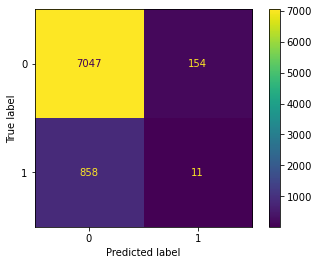

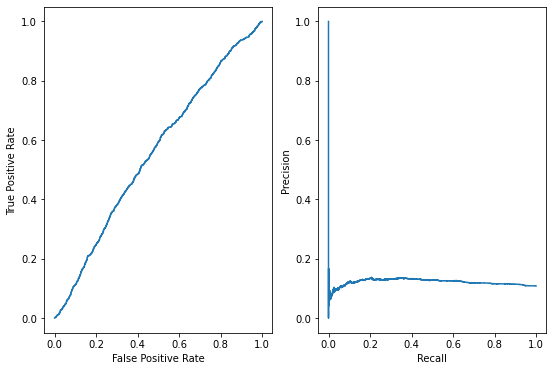

In [73]:
#  class_weight='balanced' for imbalanced dist of classes
clf = SGDClassifier(random_state = 666, class_weight='balanced', loss='log',
                    early_stopping=False, fit_intercept=True, penalty='none')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

#'''
acc_score = metrics.accuracy_score(y_test, y_pred)
#print(type(acc_score))
print('accuracy: {:.3f} '.format( acc_score ))

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score: {:.3f} '.format( f1_score ))

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)#, target_names=['Positive', 'Negative']))
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))
cm_display = ConfusionMatrixDisplay(cm).plot()

y_score = clf.decision_function(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)

## lets see if modifying thershold might help

In [74]:
threshold_list = np.linspace(0.2, 0.95, num=15)
for THRESHOLD in threshold_list:
    print ('\n******** For THRESHOLD = {:.2f} ******'.format(THRESHOLD))

    Y_test_pred = np.where(y_pred_prob[:,1] > THRESHOLD, 1, 0)

    #Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test,Y_test_pred)
    print('Our testing accuracy is {}'.format(test_accuracy))
    print(metrics.confusion_matrix(y_test, Y_test_pred))
    f1_score = metrics.f1_score(y_test, y_pred)
    print('f1 score: {:.3f} '.format( f1_score ))
    prec = metrics.precision_score(y_test, y_pred)
    print('prec score: {:.3f} '.format( prec ))
    rec = metrics.recall_score(y_test, y_pred)
    print('rec score: {:.3f} '.format( rec ))

print('end')


******** For THRESHOLD = 0.20 ******
Our testing accuracy is 0.12589838909541512
[[ 161 7040]
 [  14  855]]
f1 score: 0.021 
prec score: 0.067 
rec score: 0.013 

******** For THRESHOLD = 0.25 ******
Our testing accuracy is 0.16902106567534078
[[ 542 6659]
 [  47  822]]
f1 score: 0.021 
prec score: 0.067 
rec score: 0.013 

******** For THRESHOLD = 0.31 ******
Our testing accuracy is 0.5731102850061958
[[4178 3023]
 [ 422  447]]
f1 score: 0.021 
prec score: 0.067 
rec score: 0.013 

******** For THRESHOLD = 0.36 ******
Our testing accuracy is 0.751177199504337
[[5860 1341]
 [ 667  202]]
f1 score: 0.021 
prec score: 0.067 
rec score: 0.013 

******** For THRESHOLD = 0.41 ******
Our testing accuracy is 0.8195786864931847
[[6521  680]
 [ 776   93]]
f1 score: 0.021 
prec score: 0.067 
rec score: 0.013 

******** For THRESHOLD = 0.47 ******
Our testing accuracy is 0.8598513011152417
[[6908  293]
 [ 838   31]]
f1 score: 0.021 
prec score: 0.067 
rec score: 0.013 

******** For THRESHOLD = 0

#### now it is approximately 6-8h of focused work 

### proposed ways: try several things to improve model:
## 1) normalization of features, up to now I've tested histogram values with density=True/False (should normalize hists), however, performance is still poor
## 2) include more features in the model : not just histogram values, but also count/% of values where Pressure=0; Pressure is around mean value etc. ; maybe fit histogram with some distribution?
## 3) improve input data : fill missing values
## 4) try to deal with the imbalanced data set problem
## 5) try more alghoritms / find best params with gridsearch
